# MNIST Classification with Brevitas Quantization-Aware Training 

In this notebook, we show how to use [Brevitas](https://github.com/Xilinx/brevitas) to perform quantization-aware training on the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, using a fast FHE-friendly model with a low bit-width accumulator of 6-bits. Then, we show how the Virtual Library can be used to finetune parameters and find the best setting, before finally checking computations in FHE.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Concrete-Python
from concrete.fhe.compilation import Configuration

# The QAT model
from model import MNISTQATModel  # pylint: disable=no-name-in-module
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from tqdm import tqdm

# Concrete-ML
from concrete.ml.torch.compile import compile_brevitas_qat_model

Here are the classical functions to train and test the model.

In [2]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    """Train the model."""

    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if epoch % 4 == 0 and batch_idx % 500 == 0:
            print(
                f"Train Epoch: {epoch + 1} [{batch_idx}/{len(train_loader.dataset) // len(data)}"
                f" ({100.0 * batch_idx / len(train_loader):.0f}%)]{'':5}"
                f"\tLoss: {loss.item():.6f}"
            )

In [3]:
def test(model, device, test_loader, epoch, criterion):
    """Test the model."""

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in tqdm(test_loader, disable=epoch % 4 != 0):
            data, target = data.to(device), target.to(device)
            output = model(data).squeeze()
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if epoch % 4 == 0:
        print(
            f"Test set: Average loss: {test_loss:.4f}, "
            "Accuracy: "
            f"{correct}/{len(test_loader.dataset)} "
            f"({100.0 * correct / len(test_loader.dataset):.0f}%)"
        )

    return test_loss

In [4]:
def manage_dataset(train_kwargs, test_kwargs):
    """Get training and test parts of MNIST dataset."""

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            transforms.Lambda(torch.flatten),
        ]
    )

    # Manage datasets
    dataset1 = datasets.MNIST("./data", train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST("./data", train=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    return train_loader, test_loader

The following function is used to test the model, it can be done either using FHE execution or with FHE simulation  (i.e. on clear data).

Evaluating models using FHE simulation is a very good habit to have when working with Concrete-ML since it allows to check several aspects without having to wait for long FHE computations:
- the impact of the FHE execution on the accuracy
- the bit-widths of intermediate values, which impact FHE execution time

In [5]:
def compile_and_test(
    model,
    use_simulation,
    test_data,
    test_data_length,
    test_target,
    show_mlir,
    current_index,
):
    # Compile the QAT model and test
    configuration = Configuration(
        enable_unsafe_features=True,  # This is for our tests only, never use that in prod
        use_insecure_key_cache=True,  # This is for our tests only, never use that in prod
        insecure_key_cache_location="/tmp/keycache",
    )

    if use_simulation:
        print(f"\n{current_index}. Compiling with the Virtual Library")
    else:
        print(f"\n{current_index}. Compiling in FHE")

    q_module = compile_brevitas_qat_model(
        model,
        test_data,
        configuration=configuration,
        show_mlir=show_mlir,
    )

    # Check max bit-width
    max_bit_width = q_module.fhe_circuit.graph.maximum_integer_bit_width()

    if max_bit_width > 8:
        raise Exception(
            f"Too large bit-width ({max_bit_width}): training this network resulted in an "
            "accumulator size that is too large. Possible solutions are:"
            "    - this network should, on average, have 8bit accumulators. In your case an unlucky"
            f"initialization resulted in {max_bit_width} accumulators. You can try to train the "
            "network again"
            "    - reduce the sparsity to reduce the number of active neuron connexions"
            "    - if the weight and activation bitwidth is more than 2, you can try to reduce one "
            "or both to a lower value"
        )

    # Check the accuracy
    if use_simulation:
        print(
            f"\n{current_index + 1}. Checking accuracy with the Virtual Library "
            f"(length {test_data_length})"
        )
    else:
        print(f"\n{current_index + 1}. Checking accuracy in FHE (length {test_data_length})")

    # Key generation
    if not use_simulation:
        q_module.fhe_circuit.keygen()

    correct_fhe = 0

    # Reduce the test data, since very slow in FHE
    reduced_test_data = test_data[0:test_data_length, :]
    test_target = test_target[0:test_data_length, :]

    fhe_mode = "simulate" if use_simulation else "execute"

    prediction = q_module.forward(reduced_test_data, fhe=fhe_mode)

    correct_fhe = (np.argmax(prediction, axis=1) == test_target.ravel()).sum()

    # Final accuracy
    return correct_fhe, reduced_test_data.shape[0], max_bit_width

## Settings

Here, the user can change some settings. The most important ones are:
- epochs: how many epochs during the training
- sparsity: to define the number of active neurons in layers; make this value smaller and there will be less active neurons
- quantization_bits: the number of bits during quantization. The larger the more accurate, but also the faster we are above the limits of Concrete-ML in term of maximal bitwidth
- do_training: whether we do the training. If not, we use the previously saved ONNX model

In [6]:
# Options: the most important ones
epochs = 20
sparsity = 4
quantization_bits = 2
do_training = True

# Options: can be changed
lr = 0.02
gamma = 0.33
test_data_length_reduced = 2  # This is notably the length of the computation in FHE
test_data_length_full = 10000

# Options: no real reason to change
show_mlir = False
batch_size = 32
test_batch_size = 32
use_cuda_if_available = True
seed = None
criterion = nn.CrossEntropyLoss()

Seeding if we want to, to try to make everything as reproducible as possible.

In [7]:
# Seeding
if seed is None:
    seed = np.random.randint(0, 2**32 - 1)

print(f"\nUsing seed {seed}\n")
torch.manual_seed(seed);


Using seed 2597721155



Settings few things for the training.

In [8]:
# Training and test arguments
train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}

# Cuda management
use_cuda = torch.cuda.is_available() and use_cuda_if_available
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

print(f"\nUsing {device} device\n")


Using cuda device



Managing the MNIST data set, and splitting it into a train and testing set.

In [9]:
# Manage dataset
train_loader, test_loader = manage_dataset(train_kwargs, test_kwargs)
img_size = train_loader.dataset.data[0].shape[0]

### Defining the model

The model is defined in `model.py`. You may want to have a look to this file to see how things work in Brevitas or apply few changes here, to see what are the effects on the QAT training.

In [10]:
# Model definition
model = MNISTQATModel(quantization_bits, quantization_bits)
model = model.to(device)
model.prune(sparsity, True)

### Running the training

Below, we run the quantization-aware training, which can be quite slow.

Performing MNIST task with 2-bits in quantization and a sparsity of 4

1. Training
Train Epoch: 1 [0/1875 (0%)]     	Loss: 9.946161
Train Epoch: 1 [500/1875 (27%)]     	Loss: 0.642034
Train Epoch: 1 [1000/1875 (53%)]     	Loss: 0.238304
Train Epoch: 1 [1500/1875 (80%)]     	Loss: 0.633837


100%|██████████| 313/313 [00:02<00:00, 110.63it/s]


Test set: Average loss: 0.0150, Accuracy: 8621/10000 (86%)
Train Epoch: 5 [0/1875 (0%)]     	Loss: 0.111338
Train Epoch: 5 [500/1875 (27%)]     	Loss: 0.126882
Train Epoch: 5 [1000/1875 (53%)]     	Loss: 0.145741
Train Epoch: 5 [1500/1875 (80%)]     	Loss: 0.090589


100%|██████████| 313/313 [00:03<00:00, 102.00it/s]

Test set: Average loss: 0.0087, Accuracy: 9215/10000 (92%)


Train Epoch: 9 [0/1875 (0%)]     	Loss: 0.124798
Train Epoch: 9 [500/1875 (27%)]     	Loss: 0.090411
Train Epoch: 9 [1000/1875 (53%)]     	Loss: 0.137552
Train Epoch: 9 [1500/1875 (80%)]     	Loss: 0.052107


100%|██████████| 313/313 [00:03<00:00, 99.99it/s] 

Test set: Average loss: 0.0109, Accuracy: 8864/10000 (89%)


Train Epoch: 13 [0/1875 (0%)]     	Loss: 0.233525
Train Epoch: 13 [500/1875 (27%)]     	Loss: 0.034466
Train Epoch: 13 [1000/1875 (53%)]     	Loss: 0.214481
Train Epoch: 13 [1500/1875 (80%)]     	Loss: 0.084297


100%|██████████| 313/313 [00:03<00:00, 97.29it/s] 

Test set: Average loss: 0.0075, Accuracy: 9251/10000 (93%)


Train Epoch: 17 [0/1875 (0%)]     	Loss: 0.123085
Train Epoch: 17 [500/1875 (27%)]     	Loss: 0.076004
Train Epoch: 17 [1000/1875 (53%)]     	Loss: 0.096253
Train Epoch: 17 [1500/1875 (80%)]     	Loss: 0.114273


100%|██████████| 313/313 [00:02<00:00, 126.88it/s]

Test set: Average loss: 0.0072, Accuracy: 9297/10000 (93%)



2. Exporting to ONNX and saving the Brevitas model


/home/stoiana/Private/concrete-ml-internal/.venv/lib/python3.8/site-packages/brevitas/quant_tensor/__init__.py:65: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  training = torch.tensor(training, dtype=torch.bool)
/home/stoiana/Private/concrete-ml-internal/.venv/lib/python3.8/site-packages/brevitas/quant_tensor/__init__.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  signed = torch.tensor(signed, dtype=torch.bool)
/home/stoiana/Private/concrete-ml-internal/.venv/lib/python3

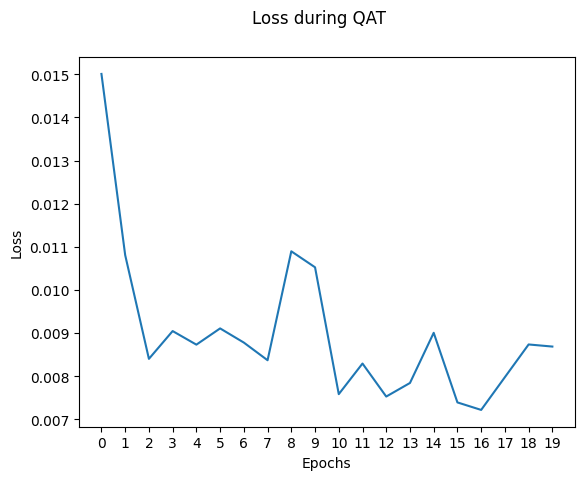

In [11]:
# Training part
print(
    f"Performing MNIST task with {quantization_bits}-bits in quantization and a "
    f"sparsity of {sparsity}"
)

if do_training:
    print("\n1. Training")
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)
    loss_values = []

    for epoch in range(epochs):
        train(model, device, train_loader, optimizer, epoch, criterion)
        cur_loss = test(model, device, test_loader, epoch, criterion)

        scheduler.step()

        loss_values.append(cur_loss)

    model.prune(sparsity, False)

    # Plot the loss
    fig = plt.figure()
    plt.plot(loss_values)
    fig.suptitle("Loss during QAT")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(range(len(loss_values)))

    # Export to ONNX
    print("\n2. Exporting to ONNX and saving the Brevitas model")
    inp = torch.rand((1, img_size * img_size)).to(device)
    torch.onnx.export(model, inp, "mnist.qat.onnx", opset_version=14)
    torch.save(model.state_dict(), "state_dict.pt")
else:
    print("\n1. Loading pre-trained model")

To avoid the training phase, you can directly load the pre-trained model by setting `do_training = False`.

In [12]:
checkpoint = torch.load("state_dict.pt")
model.load_state_dict(checkpoint)

<All keys matched successfully>

We prepare the ground truth, for final check of the model.

In [13]:
# Prepare tests
test_data = np.zeros((len(test_loader.dataset), img_size * img_size))
test_target = np.zeros((len(test_loader.dataset), 1))
idx = 0

for data, target in tqdm(test_loader):
    target_np = target.cpu().numpy()
    for idx_batch, im in enumerate(data.numpy()):
        test_data[idx] = im
        test_target[idx] = target_np[idx_batch]
        idx += 1

100%|██████████| 313/313 [00:02<00:00, 138.85it/s]


### Measuring accuracy with FHE simulation and FHE execution

Finally, we measure:
- accuracy with FHE simulation for the full test set
- accuracy with FHE simulation for the reduced test set
- accuracy in FHE for the reduced test set   

and we check that accuracy with FHE simulation and in FHE are equivalent on the reduced test set. 

Running FHE computations on a too large reduced test set may be prohibitive since we're 100% on CPU for the time being. Later, we'll have HW accelerators, to make these computations several order of magnitude faster. 

In [14]:
# Test in the VL and in FHE
accuracy = {}
current_index = 3

for use_simulation, use_full_dataset in [(True, True), (True, False), (False, False)]:
    test_data_length = test_data_length_full if use_full_dataset else test_data_length_reduced

    correct_fhe, test_data_shape_0, max_bit_width = compile_and_test(
        model.cpu(),
        use_simulation,
        test_data,
        test_data_length,
        test_target,
        show_mlir,
        current_index,
    )

    current_index += 2
    current_accuracy = correct_fhe / test_data_shape_0

    print(
        f"Accuracy in {'Simulation' if use_simulation else 'FHE'} with length {test_data_length}: "
        f"{correct_fhe}/{test_data_shape_0} = "
        f"{current_accuracy:.4f}, in {max_bit_width}-bits"
    )

    if (use_simulation, use_full_dataset) == (True, True):
        accuracy["FHE Simulation full"] = current_accuracy
    elif (use_simulation, use_full_dataset) == (True, False):
        accuracy["FHE simulation short"] = current_accuracy
    else:
        assert (use_simulation, use_full_dataset) == (False, False)
        accuracy["FHE short"] = current_accuracy


3. Compiling with the Virtual Library

4. Checking accuracy with the Virtual Library (length 10000)
Accuracy in Simulation with length 10000: 9127/10000 = 0.9127, in 6-bits

5. Compiling with the Virtual Library

6. Checking accuracy with the Virtual Library (length 2)
Accuracy in Simulation with length 2: 2/2 = 1.0000, in 6-bits

7. Compiling in FHE

8. Checking accuracy in FHE (length 2)


KeySetCache: miss, regenerating /tmp/keycache/10208169851362310863/0_0


Accuracy in FHE with length 2: 2/2 = 1.0000, in 6-bits


In [16]:
# Check that accuracy in FHE and in VL is the same
assert (
    accuracy["FHE simulation short"] == accuracy["FHE short"]
), "Error, accuracy in VL and in FHE are not the same"

# Check that accuracy is random-looking
assert accuracy["FHE Simulation full"] > 0.8, "Error, accuracy is too bad"

### Conclusion

We've shown how to train a model with Brevitas in quantization-aware training and how easy it is to obtain a satisfactory accuray of 92% even if it is lower than the state-of-the-art on cleartexts. 

Brevitas is not the only third-party package one can use for QAT. Other examples with other frameworks will certainly be added in our repository.